# Code for automated detection of GUVs in a .nd2 file

## About
This code attempts to automatically detect GUVs within a .nd2 file that contains confocal microscopy data of the sample. 

## Use of the code
In the first cell enter the `filename` (.nd2 file), `series_idx` and `channel` that should be used. Then all cell can be executed subsequently

### Pseudocode
The working machanism of the code is illustrated by the pseudocode below
```python
load_file()
preprocess() # select series and convert to correct data type
guess_initial_frame() # attempt to find the frame with most GUVs
GUVs = find_GUV_positions() # obtain xy coordinates of the GUVs
for guv in GUVs:
    properties.append(find_GUV_frames_and_properties(guv)) # obtain the frame in which the GUV intentsity is highest
print(properties) # output the analysis
```

<span style="color:red;font-weight: bold;">NOTE: all indices start at 0, so the first channel is channel <em>0</em></span>

## Features to implement/things to look at
* Look at effect of blurring radius on membrane size overestimation when using the membrane channel (solved by smaller sigma?)
* Calculate intensity of interior dye channel (green, ch 0) and look at distribution of intensity per GUV (first version done)
* Build in check to verify that the best frames were not only found at the extrema of the selected frames, if that is the case, the z_search_distance should most likely be increased to find better spots (TODO)

In [1]:
# import necessary packages
import matplotlib as mpl
import matplotlib.pyplot as plt # for plotting
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['image.cmap'] = 'gray'
import seaborn as sns

import numpy as np
import pandas as pd
from nd2reader import ND2Reader # for handling the nd2 file with PIMS
import pims # for loading files
from PIL import Image # for image processing
from collections import namedtuple # for easier handling of parameters
parameter_list = namedtuple("Parameters", "z_search_distance pixel_margin max_aspect_ratio min_radius") # define namedtuple for handling params

from skimage.filters import gaussian
from skimage.measure import label,regionprops
from skimage.feature import canny
from scipy import ndimage as ndi

# Set the variables in the cell below

In [2]:
# setting variables
filename = "../galvano_003_10series.nd2" # path to the nd2 file
# filename = "../test_data/high-density/z-stack zoomed in008.nd2" # path to the nd2 file
channel = 0 # index of the channel to use
series_idx = 8 # integer or None in case of a file with a single series

params = parameter_list(z_search_distance   =   7,   # number of frames to go up and down to find highest intensity
                       pixel_margin         =   15,  # number of pixels to increase the box on each side when browsing z stack
                       max_aspect_ratio     =   1.3, # maximum aspect ratio of a GUV (always larger than 1)
                       min_radius           =   7,   # minimal radius of a GUV in pixels
                       )
# =========================================================================
# =========================================================================
# === do not adjust the code below, unless you know what you are doing! ===
# =========================================================================
# =========================================================================

# Running the actual analysis

In [4]:
# definine some helper functions
@pims.pipeline
def as_8bit(frame):
    imin = frame.min()
    imax = frame.max()
    a = (255 - 0) / (imax - imin)
    b = 255 - a * imax
    return (a * frame + b).astype(np.uint8)

@pims.pipeline
def gaussian_5px(frame):
    return gaussian(frame, 5)

def bounded_range(orig_range, min_val, max_val): # remove all items from a range that are outside (min,max)
    l = []
    for i in orig_range:
        if i >= min_val and i <= max_val:
            l.append(i)
    return l
#     return slice(np.min(l),np.max(l)+1)

@pims.pipeline
def process_find_edges(frame):
    return ndi.binary_fill_holes(canny(frame, sigma=1, low_threshold=20, high_threshold=50))

def image_subregion(frame, xlims=[0,100], ylims=[0,100], circular=False):
    xmin = xlims[0] if xlims[0] >= 0 else 0
    xmax = xlims[1] if xlims[1] < frame.shape[1] else frame.shape[1]-1
    ymin = ylims[0] if ylims[0] >= 0 else 0
    ymax = ylims[1] if ylims[1] < frame.shape[0] else frame.shape[0]-1
    newframe = frame[slice(ymin,ymax),slice(xmin,xmax)]
    if circular:
        area = newframe.size
        # assume spherical
        r = int((xmax-xmin)/2)
        for x in range(newframe.shape[1]):
            for y in range(newframe.shape[0]):
                dx = x-r
                dy = y-r
                if dx**2+dy**2 > r**2:
                    newframe[y,x] = 0
                    area -= 1 # subtract area by one
        return (newframe,area) # in case of a circle return (image, circle_area(px))
    return (newframe,xmin,ymin) # in case of a square return (image,xmin,ymin)

def scaled_GUV_intensity(frame, guv):
    x,y,r = (guv['x'],guv['y'],guv['r'])
    subregion, circle_area = image_subregion(frame, xlims=[x-r,x+r],ylims=[y-r,y+r], circular=True)
#     nonzero_subregion = subregion[np.nonzero(subregion)]
    intensity = subregion.sum()/(circle_area * np.iinfo(subregion.dtype).max) # scale by value if complete area had max intensity
#     intensity = nonzero_subregion.mean()/float(np.iinfo(subregion.dtype).max) # scale by value if complete area had max intensity
    return intensity
    
def ar(rp):
    if rp['minor_axis_length'] == 0.:
        return rp['major_axis_length']
    else:
        return rp['major_axis_length']/rp['minor_axis_length']
    

In [5]:
# Loading and processing the file
stack = pims.open(filename)
stack.bundle_axes = 'yx' # have only yx data in one frame
stack.iter_axes = 'z' # iterate over the z axis
stack.default_coords['c'] = channel # select the correct channel
if series_idx and 'v' in stack.sizes:
    stack.default_coords['v'] = series_idx # select the correct channel
stack.default_coords['t'] = 0 # single time
metadata = stack.metadata

frames = as_8bit(stack) # convert to 8-bit image

print("Processing series %d of file '%s' with %d frames by using selected channel '%s' (#%d)" % (series_idx, filename, len(stack), metadata['channels'][channel], channel))

Processing series 8 of file '../galvano_003_10series.nd2' with 31 frames by using selected channel 'Alexa 488 antibody' (#0)


Centers for 40 GUVs were found


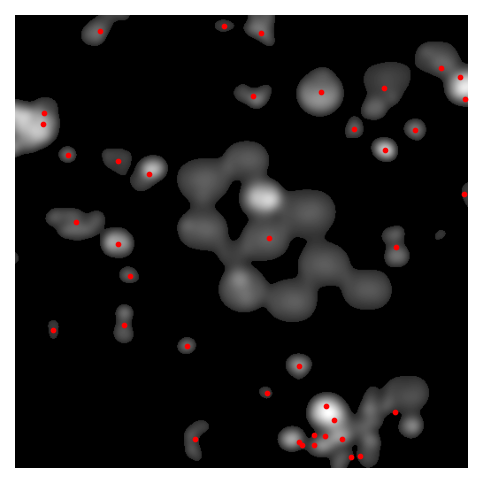

In [155]:
total_intensities = np.zeros((len(frames)))
for i,f in enumerate(frames):
    total_intensities[i] = gaussian_5px(f).sum()
# best_frame = np.argmax(total_intensities)
best_frame = 2

# make mean image
frames_for_mean = bounded_range(range(best_frame-2, best_frame+3), 0, len(frames)) # make a sublist of 3 frames below and above best_frame (if possible)
mean_image = as_8bit(np.array(gaussian_5px(frames[frames_for_mean])).mean(axis=0)) # take the mean image of that substack
filled = ndi.binary_fill_holes(canny(mean_image,sigma=3, low_threshold=20, high_threshold=50)) # do an edge detection and fill the holes 
regions = regionprops(label(filled)) # get information about the different regions in the image

centroids = np.ceil(np.array(list(map(lambda x: (x.centroid[1], x.centroid[0]), regions)))).astype(np.uint) # get the centres of each of the GUVs
radii = np.ceil(0.5 * np.array(list(map(lambda x: x.major_axis_length, regions)))).astype(np.uint) # and their respective radii

fig,ax = plt.subplots(1,1)
ax.imshow(mean_image)
xs,ys = zip(*centroids)
ax.scatter(xs,ys, c='r', s=3)
plt.axis('off')
print("Centers for %d GUVs were found" % len(radii))

C:\Users\Roy\Documents\AMOLF\GUV-analysis\venv\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


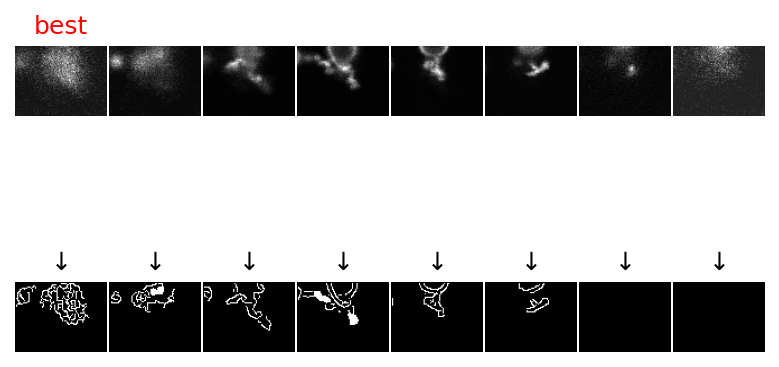

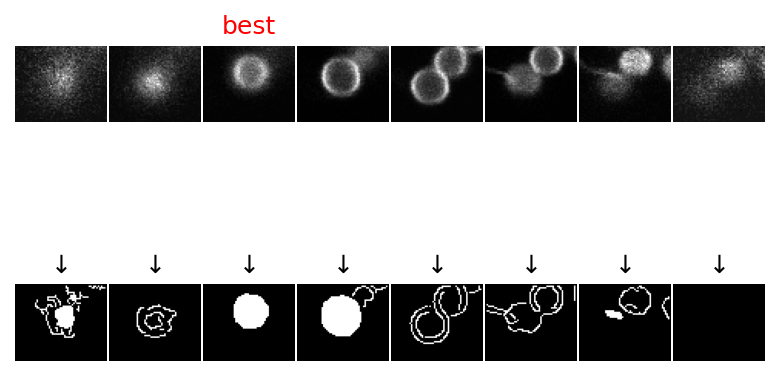

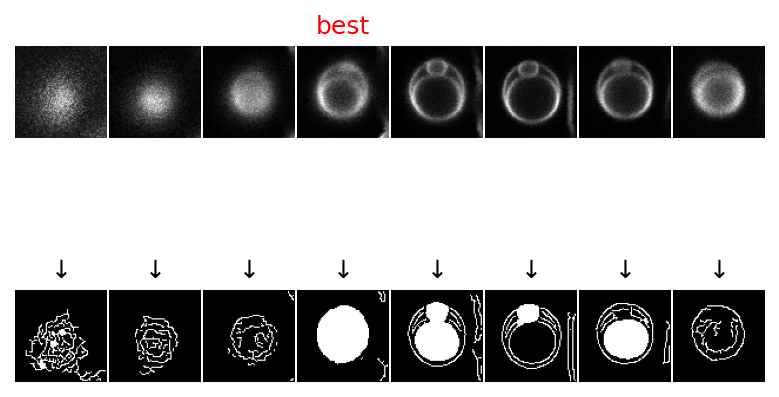

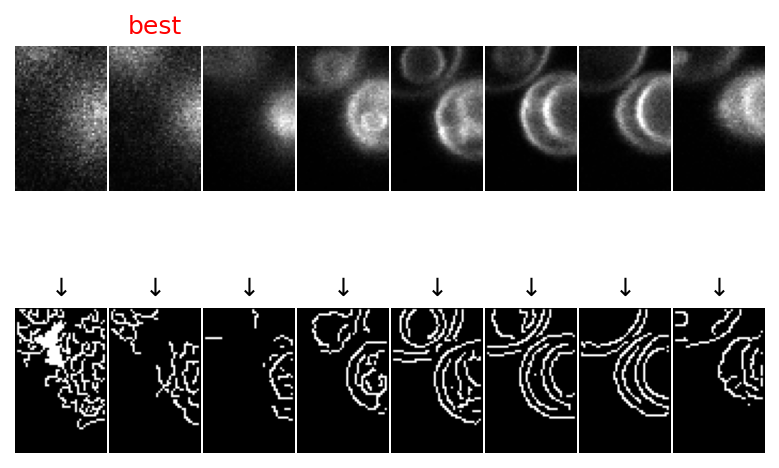

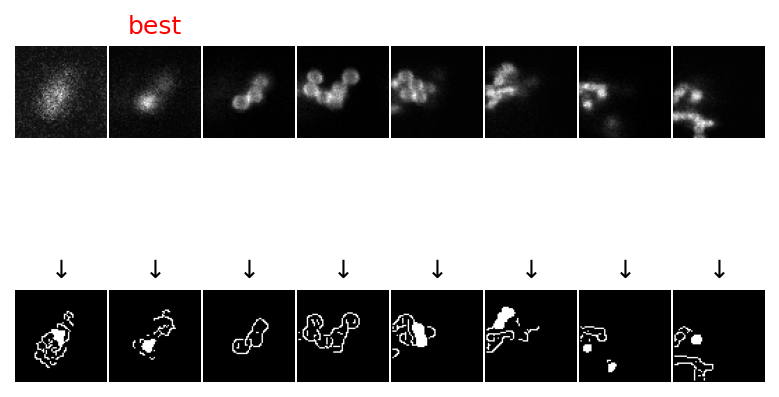

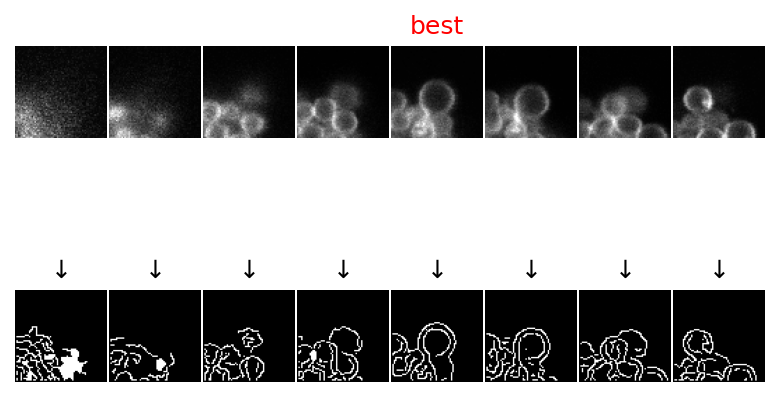

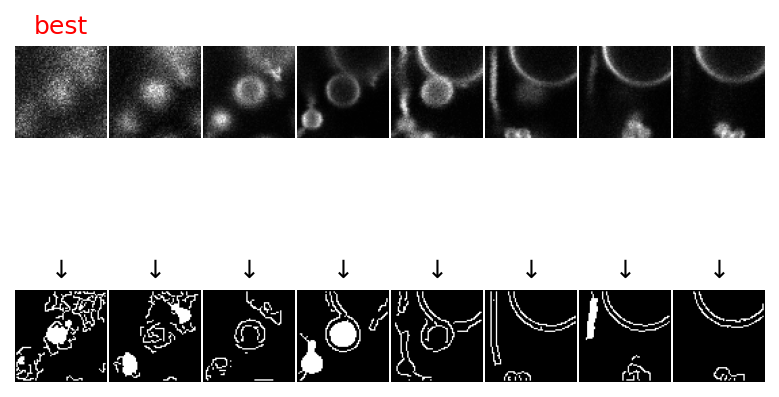

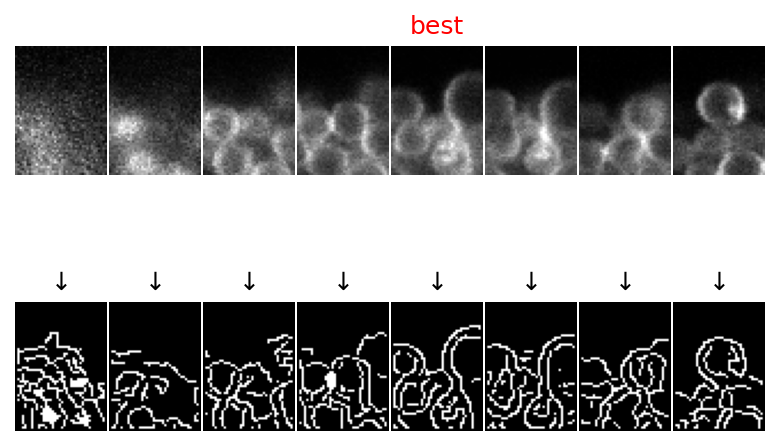

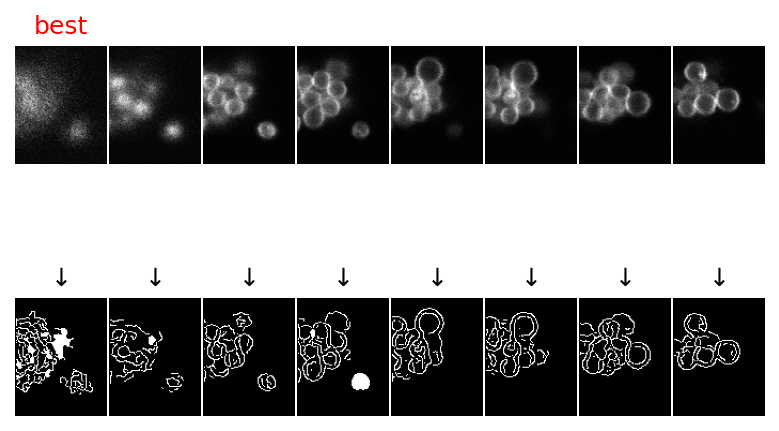

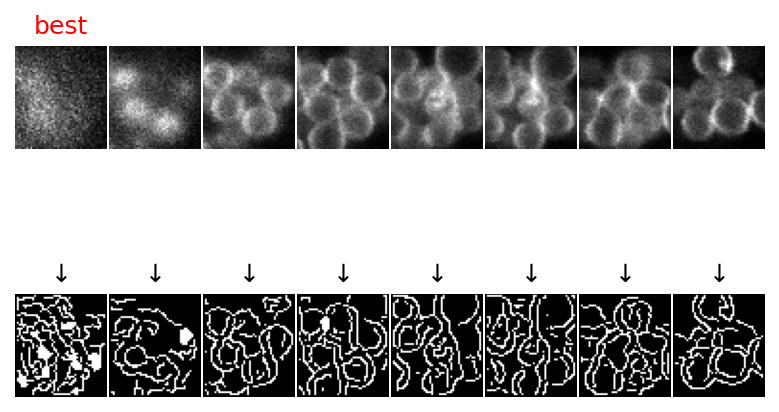

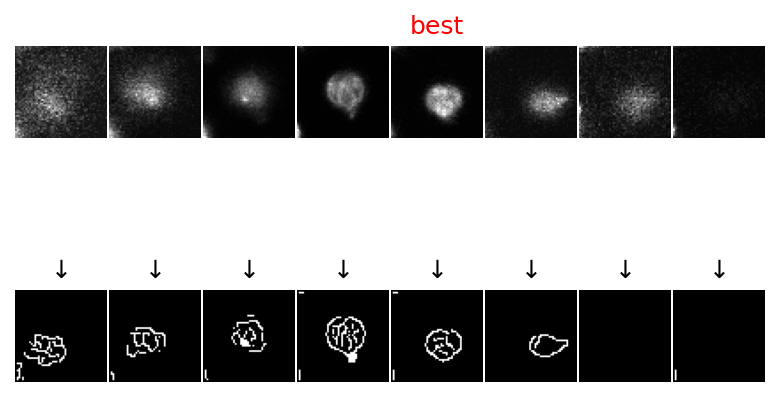

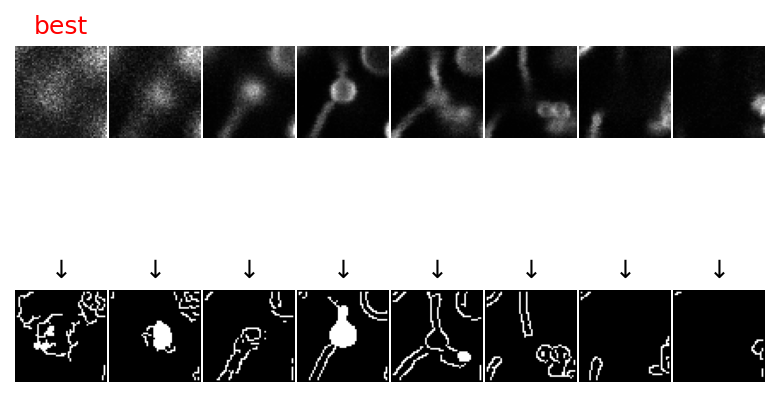

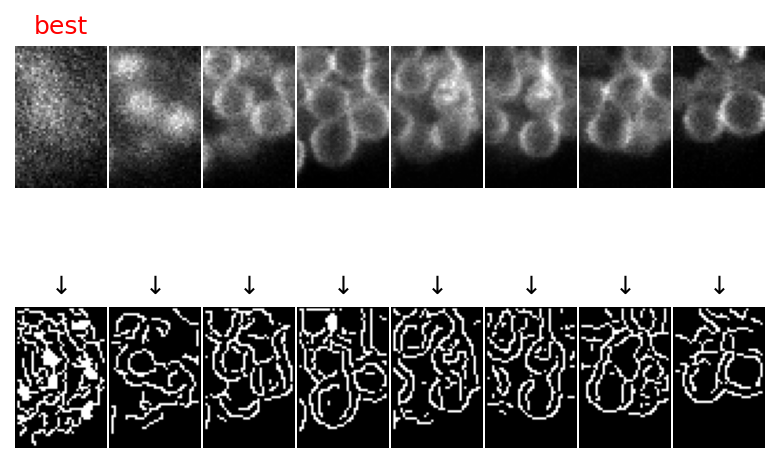

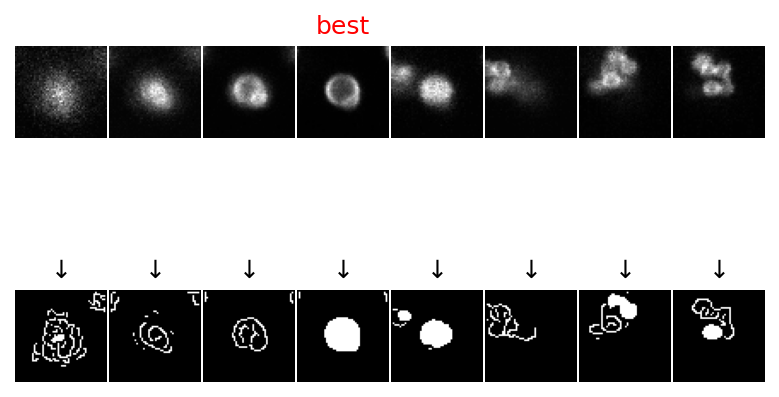

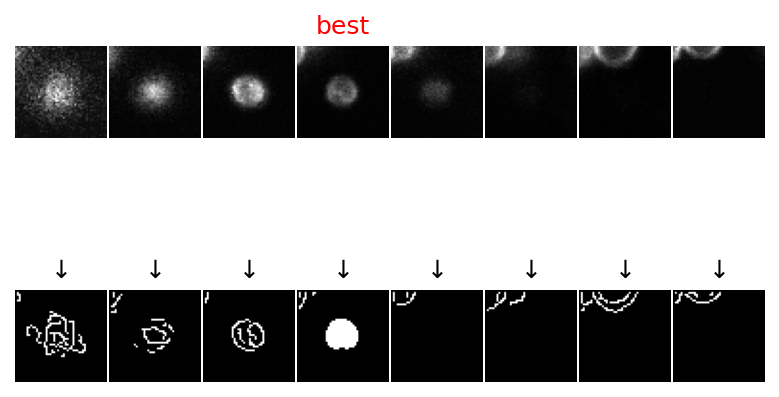

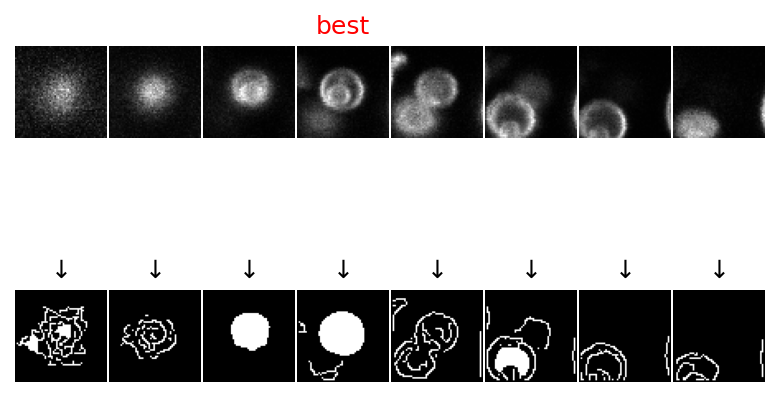

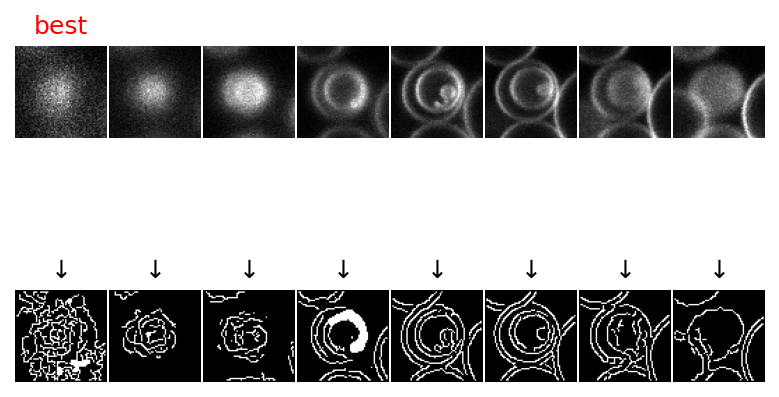

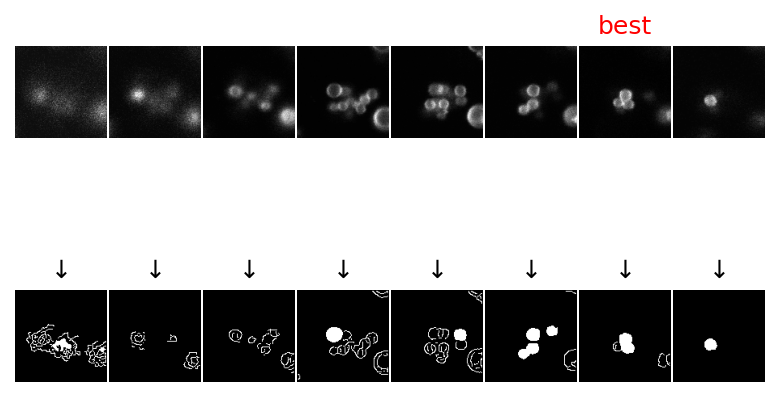

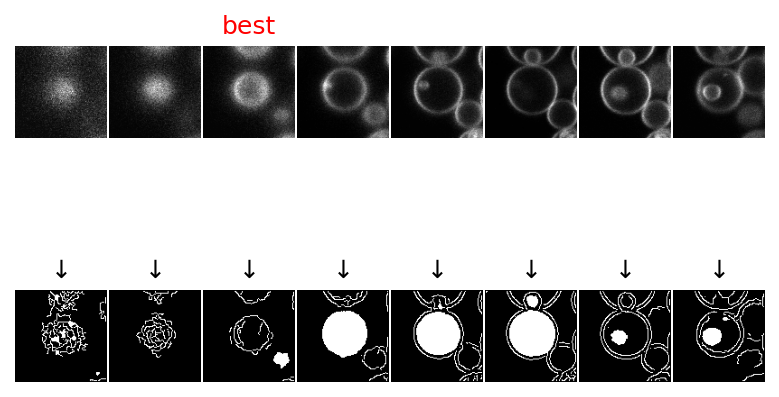

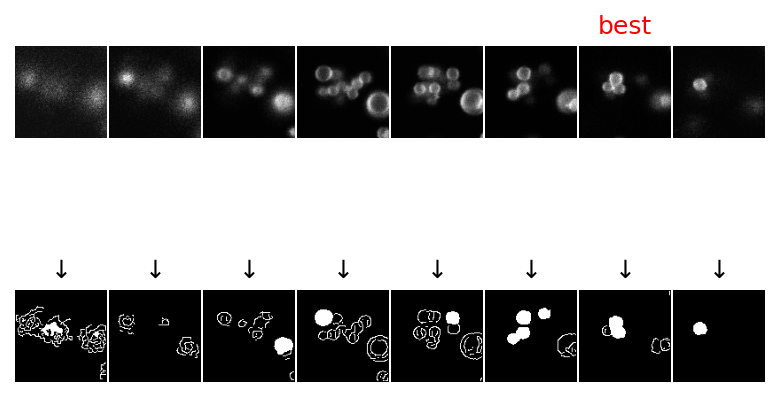

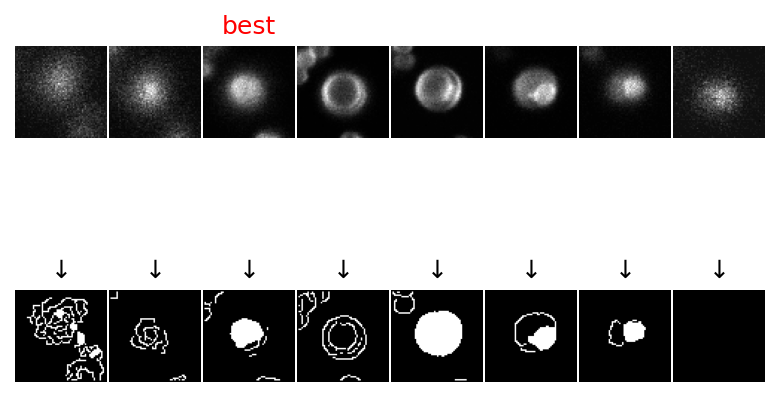

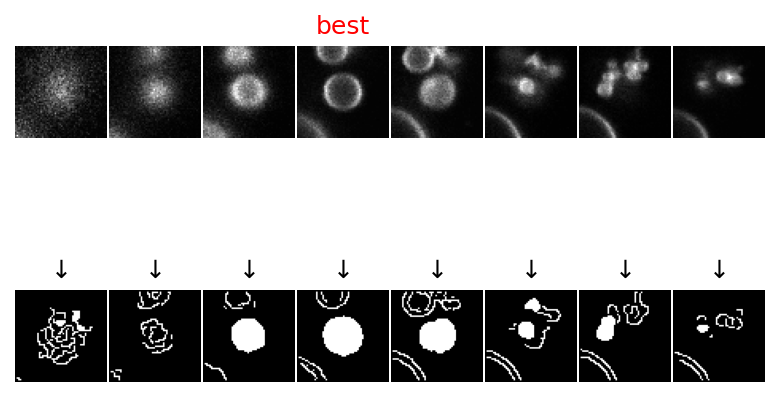

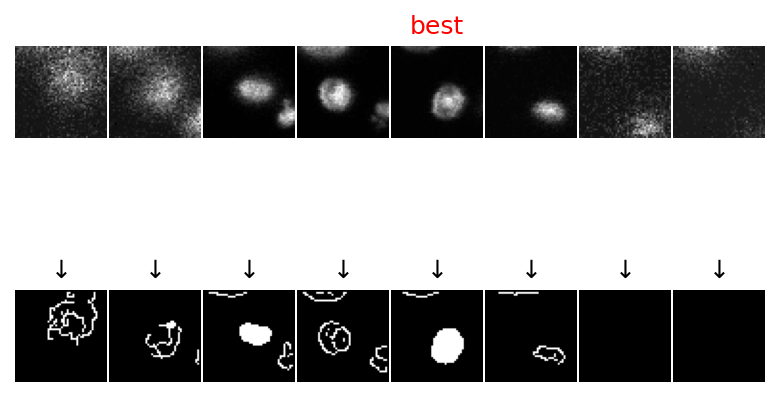

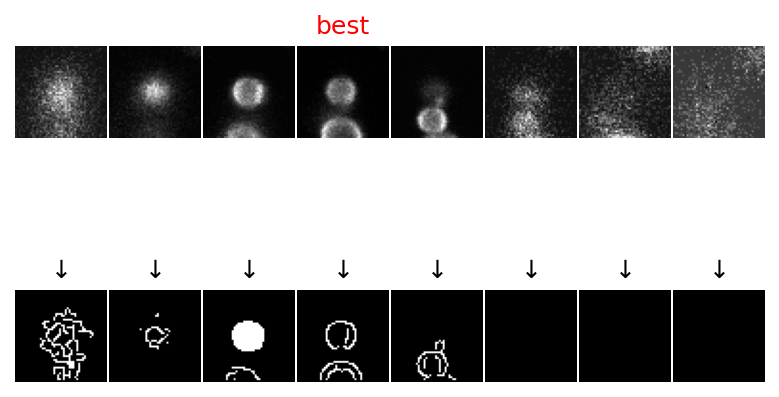

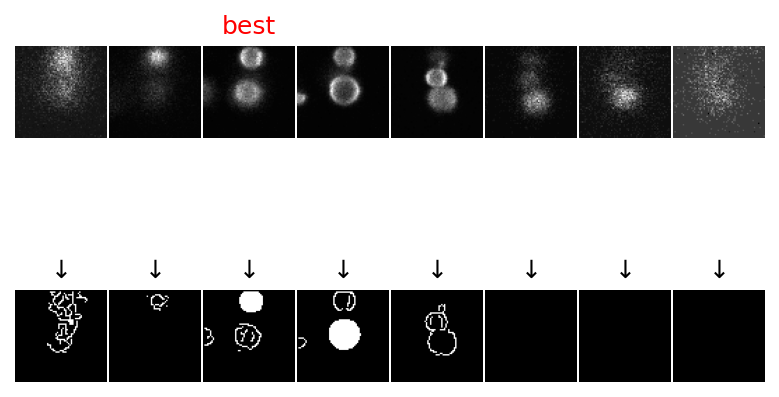

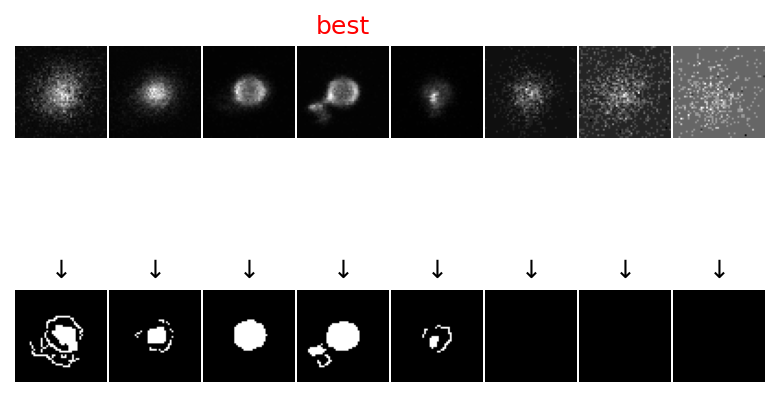

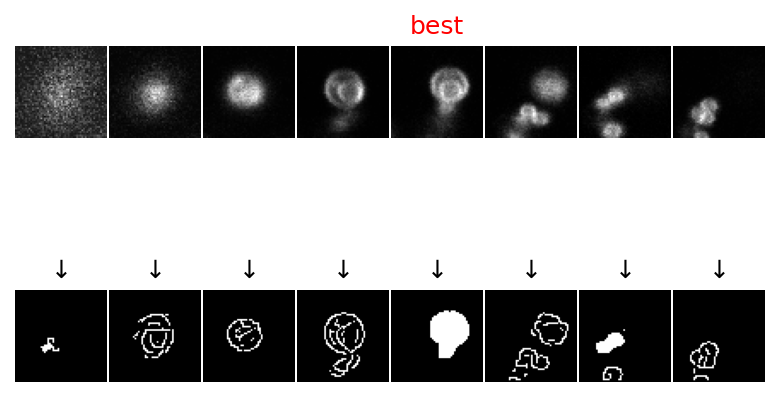

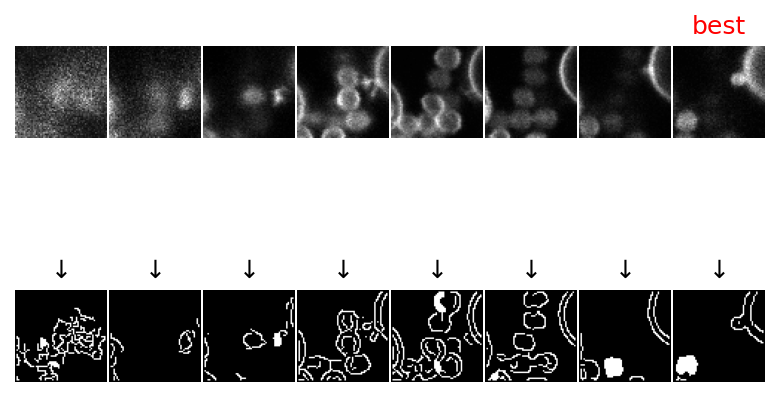

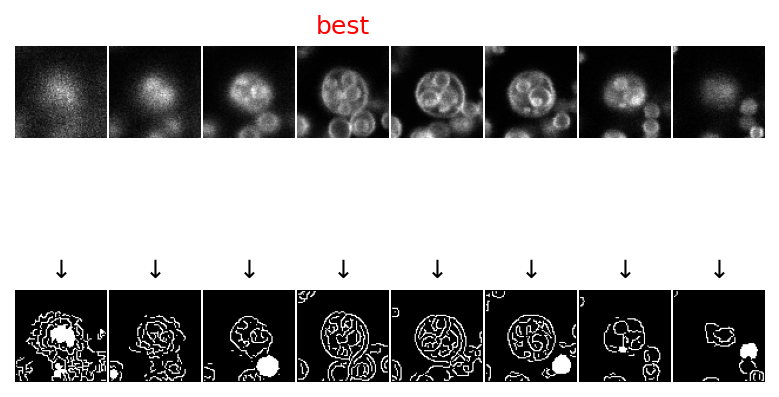

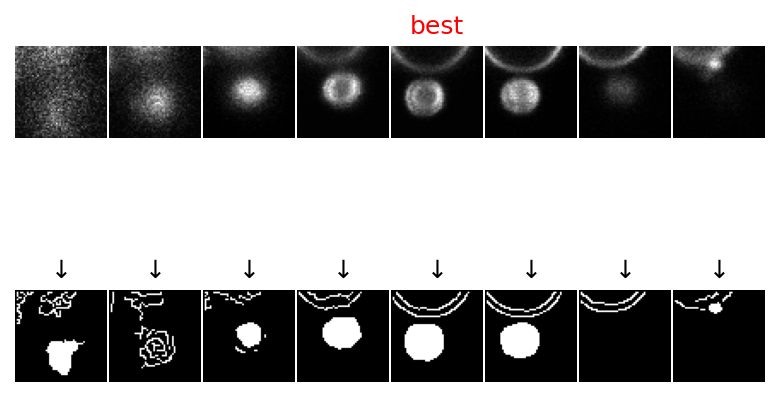

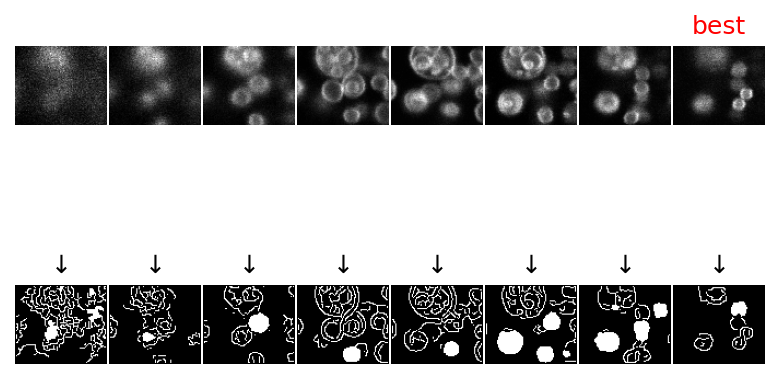

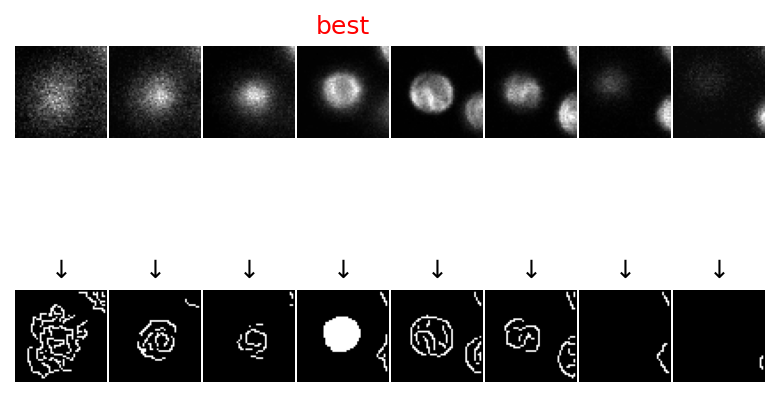

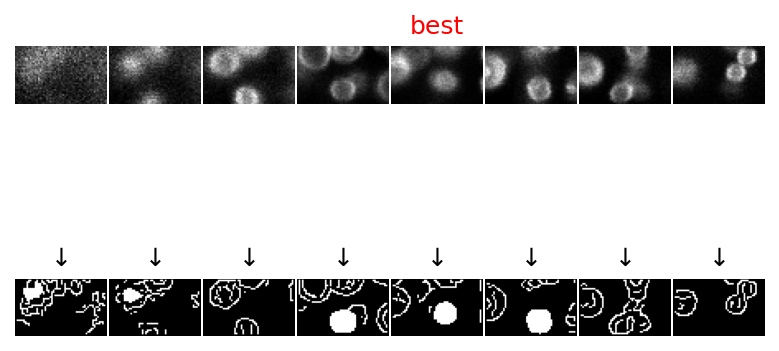

In [128]:
# process the GUVs one by one to find the frame with highest area
guv_properties = []
for i in range(len(centroids)):
    c = centroids[i]
    x,y = c[0],c[1]
    r = radii[i]+params.pixel_margin
    frames_for_finding_maxInt = bounded_range(range(best_frame-params.z_search_distance, best_frame+params.z_search_distance+1), 0, len(frames))
    figw, figh = mpl.figure.figaspect(.1*len(frames_for_finding_maxInt))
    fig,ax = plt.subplots(2,len(frames_for_finding_maxInt),figsize=(figw, figh))
    local_regions = []
    for i,f in enumerate(frames_for_finding_maxInt):
        img_raw,xmin,ymin = image_subregion(frames[f], [x-r,x+r], [y-r,y+r])
        ax[0,i].imshow(img_raw)
        ax[0,i].axis('off')
        img = process_find_edges(img_raw)
        regs = regionprops(label(img))
        filtered_regs = filter(lambda x: ar(x) < params.max_aspect_ratio, regs) # filter regions with a too high aspect ratio 
        sorted_local_regions = sorted(filtered_regs, key = lambda i: i['area']) # sort filtered regions by decreasing area
        if sorted_local_regions: 
            local_regions.append(sorted_local_regions[0])
        else:
            local_regions.append({'area': 0, 'centroid': (0,0), 'major_axis_length': 0.}) # no regions found, so add empty one
        ax[1,i].imshow(img)
#         if f == best_frame:
#             ax[0,i].set_title('start')
        ax[1,i].axis('off')
        ax[1,i].set_title(r"↓")
    areas = list(map(lambda x: x['area'], local_regions))
    max_area_idx = np.argmax(areas)
    if local_regions[max_area_idx]['major_axis_length'] > params.min_radius:
        guv_properties.append({'frame': frames_for_finding_maxInt[max_area_idx],
                               'x': np.round(local_regions[max_area_idx]['centroid'][1]+xmin).astype(int),
                               'y': np.round(local_regions[max_area_idx]['centroid'][0]+ymin).astype(int),
                               'area': local_regions[max_area_idx]['area'],
                               'r': np.sqrt(local_regions[max_area_idx]['area']/np.pi), # spherical, so calculate r from area
                              })
    ax[0,max_area_idx].set_title('best', c='r')
    plt.tight_layout(pad=0.0, w_pad=0.1, h_pad=0.0)
plt.show()

In [91]:
# calculate the scaled intensity for each of the GUVs
intensity_channel = 0
stack.default_coords['c'] = intensity_channel
intensities = []
# for idx,guv in data.iterrows():
for guv in guv_properties:
    guv['intensity'] = scaled_GUV_intensity(frames[guv['frame']], {'x': guv['x'], 'y': guv['y'], 'r': np.ceil(guv['r']).astype(int)})

# set channel back
stack.default_coords['c'] = channel

guv_data = pd.DataFrame(guv_properties)

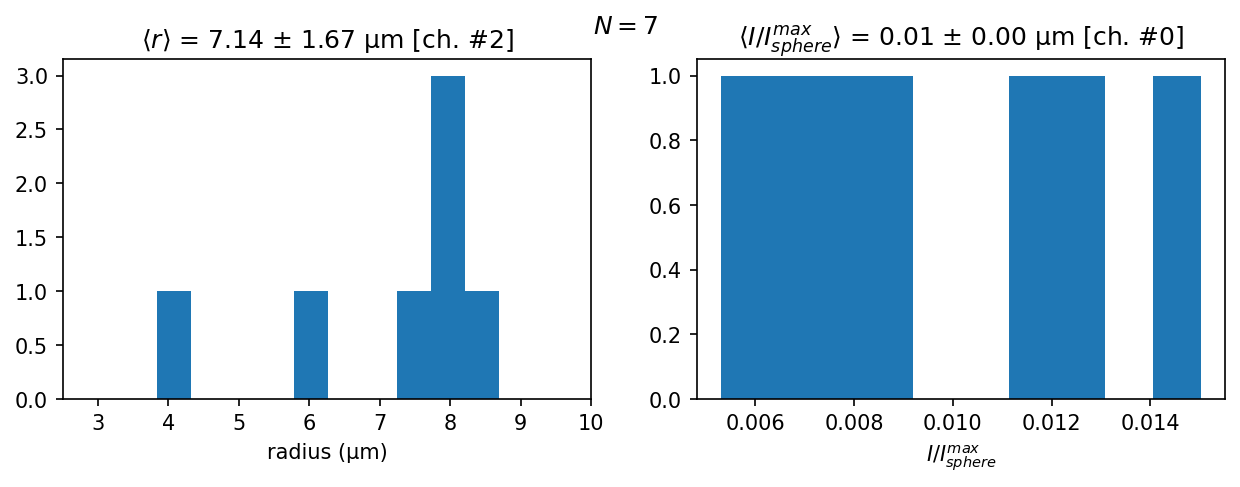

In [92]:
# output some statistics
guv_data['r_um'] = guv_data['r']*metadata['pixel_microns']

fig,ax = plt.subplots(1,2,figsize=(10,3))
# print("Found %d GUVs with an average radius of %.02f ± %.02f µm" % )
ax[0].hist(guv_data['r_um'])
ax[0].set_title(r"$\langle r \rangle$ = %.02f ± %.02f µm [ch. #%d]" % (guv_data['r_um'].mean(), guv_data['r_um'].std(), channel))
ax[0].set_xlabel(r"radius (µm)")
ax[0].set_xlim(2.5,10.)
# plt.savefig("histogram_radii_ch%d.png" % channel, bbox_inches='tight')

ax[1].hist(guv_data['intensity'])
ax[1].set_title(r"$\langle I/I^{max}_{sphere} \rangle$ = %.02f ± %.02f µm [ch. #%d]" % (guv_data['intensity'].mean(), guv_data['intensity'].std(), intensity_channel))
ax[1].set_xlabel(r"$I/I^{max}_{sphere}$")
# ax[1].set_xlim(0.,1.)

fig.suptitle(r"$ N = %d$" % guv_data.shape[0])
plt.savefig("histograms_r-intensity_ch%d.png" % channel, bbox_inches='tight')


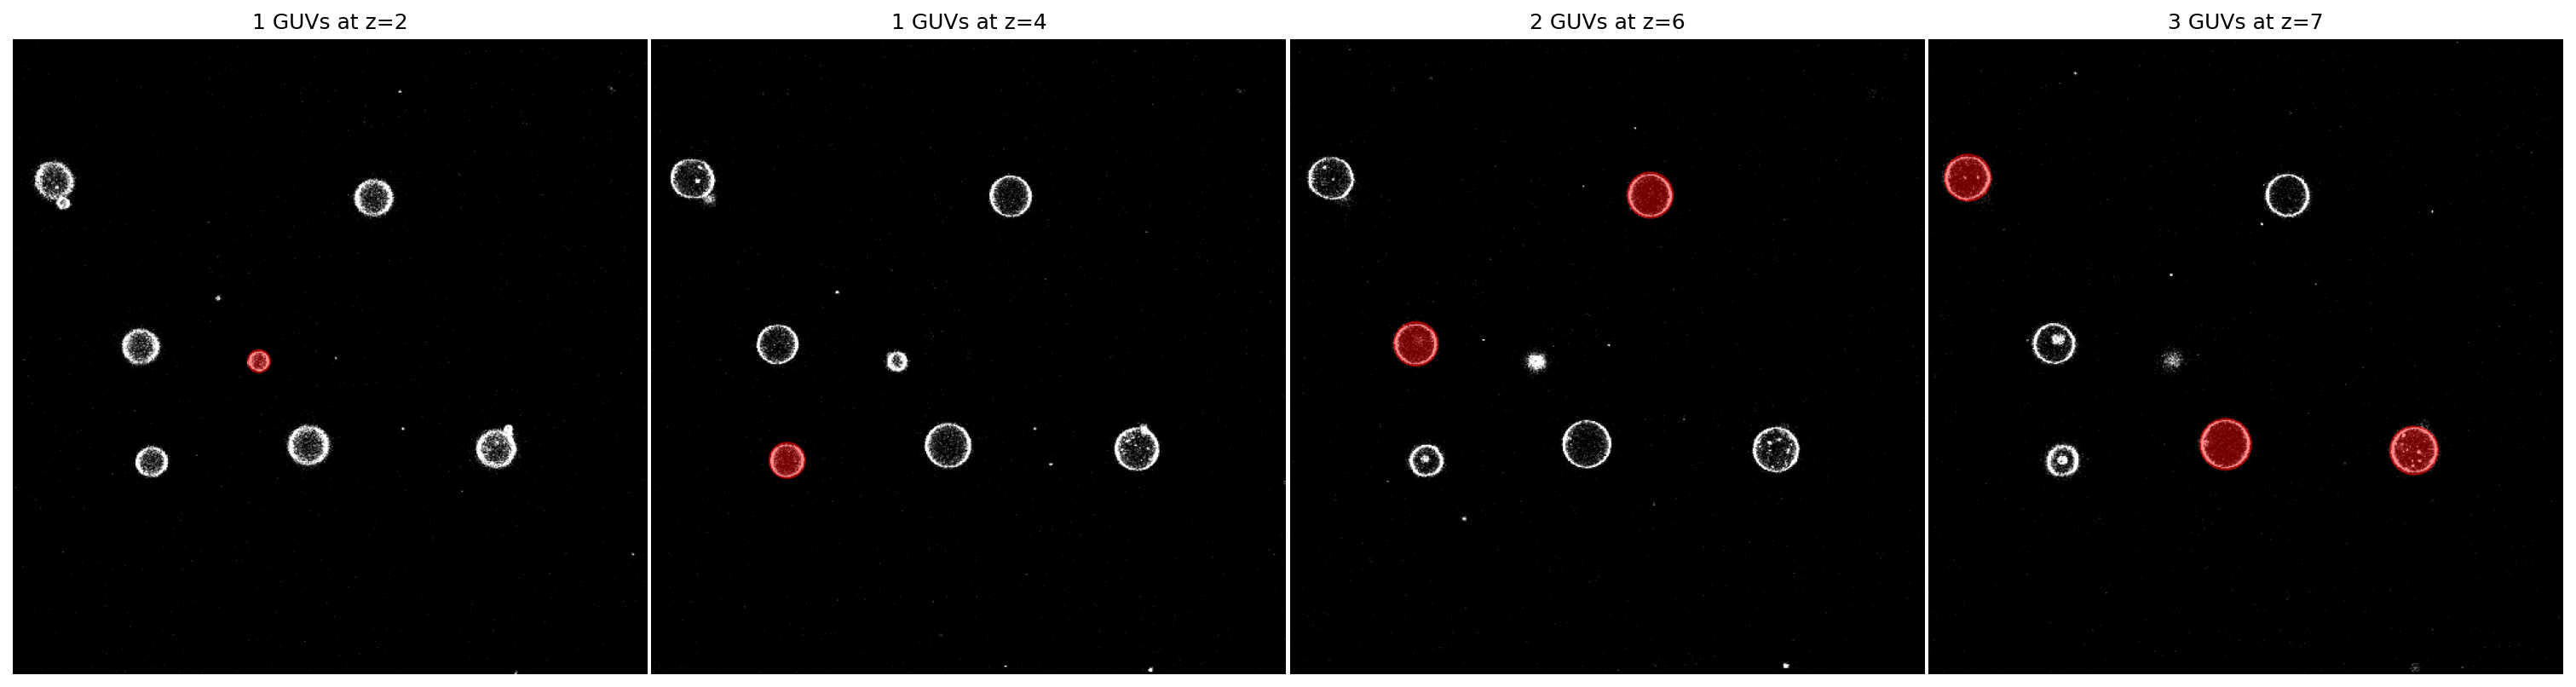

In [95]:
# annotate the frames
from matplotlib.patches import Circle
nonempty_frames = np.unique(list(map(lambda x: x['frame'], guv_properties)))
fig,axs = plt.subplots(1,len(nonempty_frames), figsize=(5*len(nonempty_frames),5))
for i,f in enumerate(nonempty_frames):
    guvs = list(filter(lambda x: x['frame'] == f,guv_properties))
    axs[i].imshow(frames[f])
    axs[i].set_title("%d GUVs at z=%d" % (len(guvs), f))
    axs[i].axis('off')
    for guv in guvs:
        axs[i].add_artist(Circle(xy=(guv['x'],guv['y']),radius=guv['r'],ec='r',facecolor='r',alpha=.45))

plt.tight_layout(pad=0.1)
plt.savefig("result_tracking_ch%d.jpg" % channel,dpi=150,bbox_inches='tight')

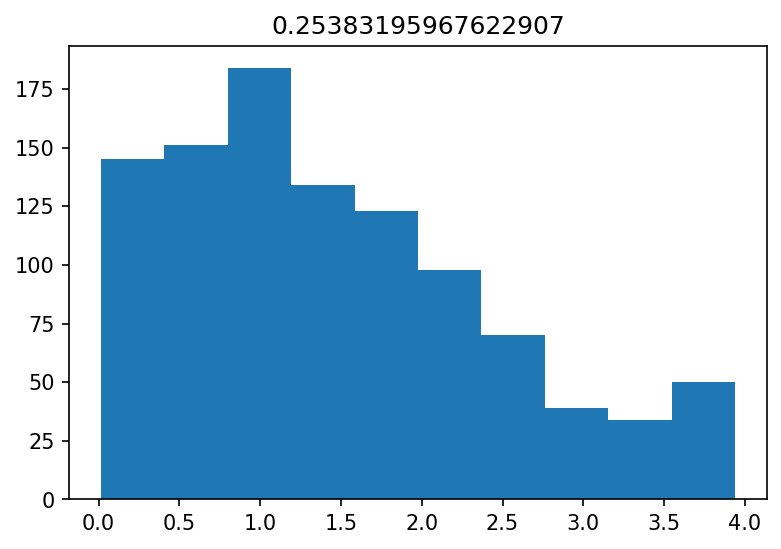

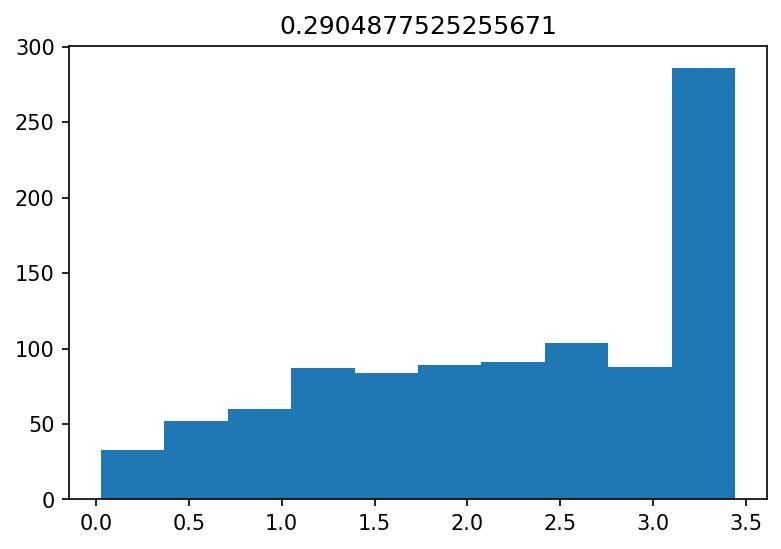

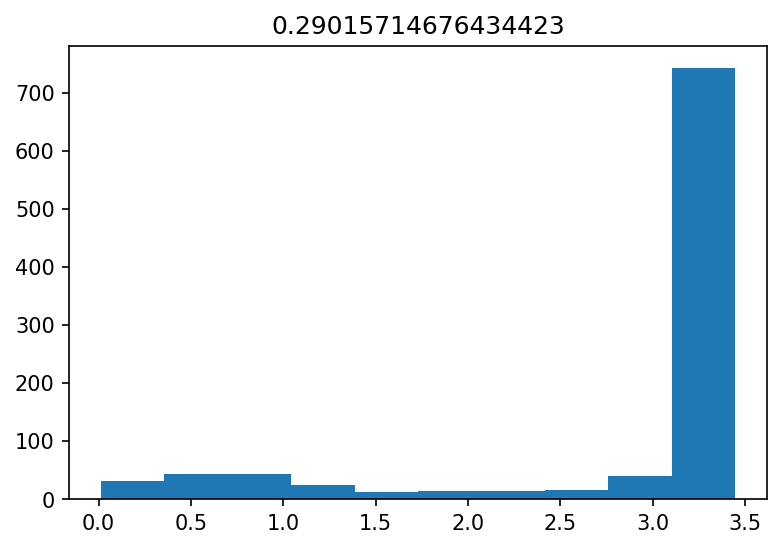

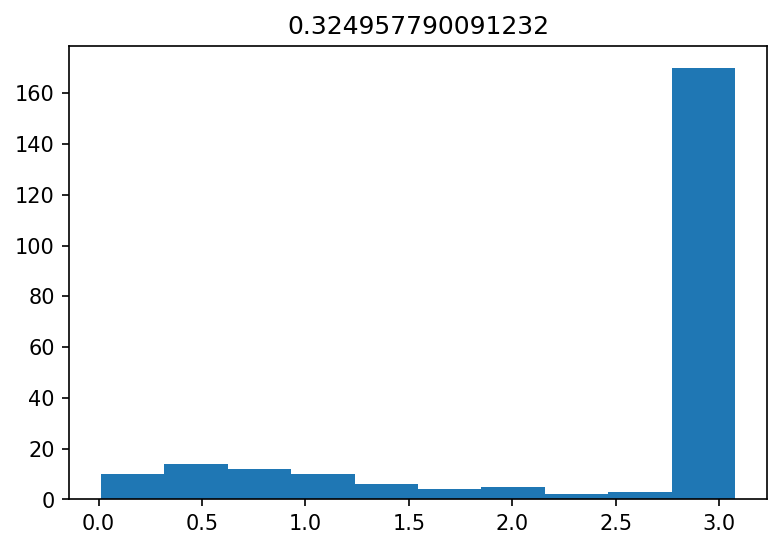

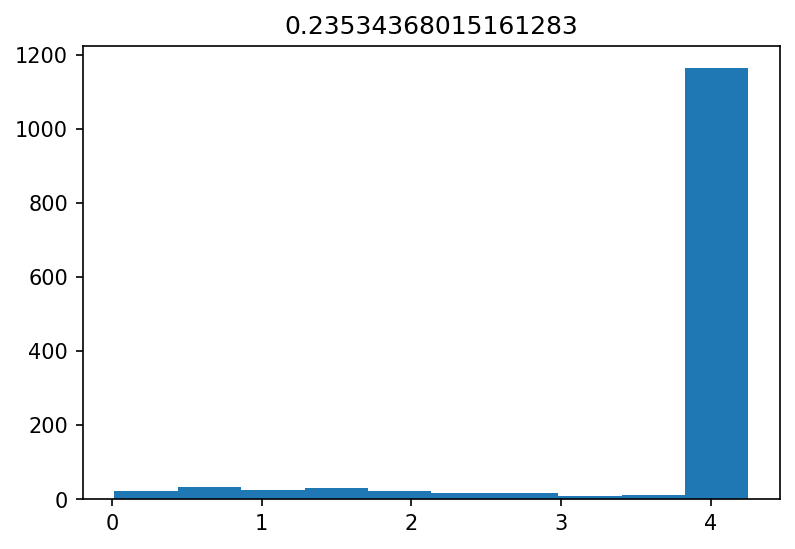

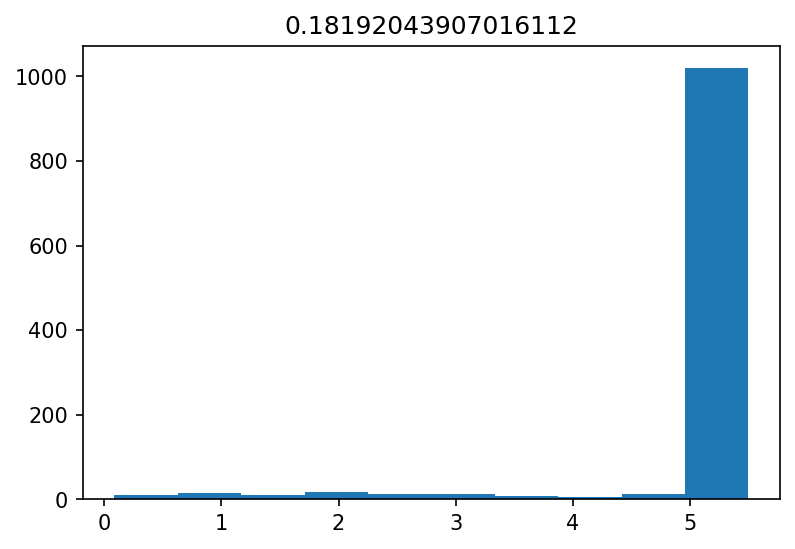

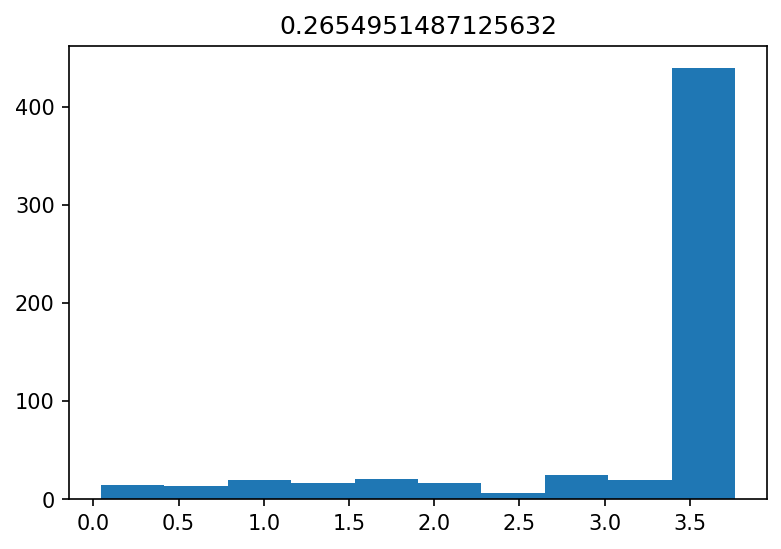

In [110]:
# calculate the intensity of the green channel
intensity_channel = 0
stack.default_coords['c'] = intensity_channel

for guv in guv_properties:
    r = int(np.round(guv['r']))
    subimg,*_ = image_subregion(frames[guv['frame']],[guv['x']-r,guv['x']+r],[guv['y']-r,guv['y']+r],circular=True) 
    intensity = scaled_GUV_intensity(frames[guv['frame']], {'x': guv['x'], 'y': guv['y'], 'r': np.ceil(guv['r']).astype(int)})
    plt.figure()
#     a = plt.imshow(subimg/subimg.std())
#     print(subimg[subimg.nonzero()].hist())
    i = subimg/255.
    plt.hist(i[subimg.nonzero()]/i[subimg.nonzero()].std())
    plt.title(i[subimg.nonzero()].std())
#     plt.colorbar(a)
#     plt.title("%.02f" % (100*intensity)) # normalize intensity by max intensity (all of area = 255)

# set channel back
stack.default_coords['c'] = channel